## Set-Up

In [1]:
import numpy
import networkx
import epyc
import epydemic
import pandas
import mpmath
import random

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=1.75)
from math import exp
pandas.set_option('display.max_columns', 500)
pandas.set_option('display.width', 1000)

In [2]:
class PLCNetworkDynamics(epydemic.StochasticDynamics):
    
    # Experimental paramerters
    N = 'N'
    ALPHA = 'alpha'
    CUTOFF = 'cutoff'
    RDSEED = 'rdseed'
    
    def __init__(self, p):
        super(PLCNetworkDynamics, self).__init__(p)

    def makePowerlawWithCutoff(self, alpha, cutoff):
        C = 1.0 / mpmath.polylog(alpha, numpy.exp(-1.0 / cutoff))
        def p(k):
            return (pow((k + 0.0), -alpha) * numpy.exp(-(k + 0.0) / cutoff)) * C
        return p
    
    def generatePLC(self, N, alpha, cutoff, rdseed, maxdeg=100):
        p = self.makePowerlawWithCutoff(alpha, cutoff)
        random.seed(rdseed)
        rng = numpy.random.default_rng()
        ns = []
        t = 0
        for i in range(N):
            while True:
                k = rng.integers(1, maxdeg)
                if rng.random() < p(k):
                    ns.append(k)
                    t += k
                    break
        while t % 2 != 0:
            i = rng.integers(0, len(ns) - 1)
            t -= ns[i]
            del ns[i]
            while True:
                k = rng.integers(1, maxdeg)
                if rng.random() < p(k):
                    ns.append(k)
                    t += k
                    break
        return networkx.configuration_model(ns, create_using=networkx.Graph())

    def configure(self, params):
        super(PLCNetworkDynamics, self).configure(params)
        
        # build a random powerlaw-with-cutoff network with the given parameters
        N = params[self.N]
        alpha = params[self.ALPHA]
        cutoff = params[self.CUTOFF]
        rdseed = params[self.RDSEED]
        g = self.generatePLC(N, alpha, cutoff, rdseed)
        self.setNetworkPrototype(g)

In [3]:
class MonitoredSIR(epydemic.SIR, epydemic.Monitor):
 
    def __init__(self):
        super(MonitoredSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredSIR, self).build(params)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)

In [4]:
class MonitoredVaccinatedSIR(epydemic.SIR, epydemic.Monitor):
    
    P_VACCINATED = 'pVaccinated'   #: Probability that an
                                   # individual is initially removed.
    
    def __init__(self):
        super(MonitoredVaccinatedSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredVaccinatedSIR, self).build(params)

        # change the initial compartment probabilities to vaccinate (remove) some fraction
        pInfected = params[epydemic.SIR.P_INFECTED]
        pVaccinated = params[self.P_VACCINATED]
        self.changeCompartmentInitialOccupancy(epydemic.SIR.INFECTED, pInfected)
        self.changeCompartmentInitialOccupancy(epydemic.SIR.REMOVED, pVaccinated)
        self.changeCompartmentInitialOccupancy(epydemic.SIR.SUSCEPTIBLE, 1.0 - pInfected - pVaccinated)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)

In [5]:
class MonitoredVaccinatedHighDegreeSIR(MonitoredSIR):

    K_VACCINATED_FRACTION = 'k_vaccinated_fraction'
    
    def __init__(self):
        super(MonitoredVaccinatedHighDegreeSIR, self).__init__()
        
    def setUp(self, params):
        super(MonitoredVaccinatedHighDegreeSIR, self).setUp(params)

        # look for the fraction of highest-degree nodes
        # and vaccinate (remove) them
        g = self.network()
        ns = list(g.nodes())
        h = int(len(ns) * params[self.K_VACCINATED_FRACTION])
        degrees = dict(networkx.degree(g))
        ks = sorted(list(degrees.values()))
        ks_high = set(ks[-h:])
        ns_high = [n for n in ns if degrees[n] in ks_high]
        for n in random.sample(ns_high, int(len(ns_high)*0.8)):
            # remove (vaccinate) the node
            self.setCompartment(n, self.REMOVED)

## Single Simulation Runs

In [6]:
# network parameters
N = 10000
alpha = 2

# simulation time
T = 1000

# disease dynamic parameters
pInfected = 0.005
pInfect = 0.01
pRemove = 1-exp(-1/14 * 0.05)

In [7]:
# set up the experiment
lab = epyc.Lab()
lab[epydemic.SIR.P_INFECTED] = pInfected
lab[epydemic.SIR.P_INFECT] = pInfect
lab[epydemic.SIR.P_REMOVE] = pRemove
lab[PLCNetworkDynamics.N] = N
lab[PLCNetworkDynamics.ALPHA] = alpha
lab[PLCNetworkDynamics.CUTOFF] = 60
lab[PLCNetworkDynamics.RDSEED] = 42

# timesteps
lab[epydemic.Monitor.DELTA] = T / 50

#### Vaccinating at Random

In [8]:
# vaccinate 75% of pop with 80% vaccine efficacy
pVaccinated = 0.75 * 0.8

In [9]:
lab[MonitoredVaccinatedSIR.P_VACCINATED] = pVaccinated

m = MonitoredVaccinatedSIR()
e = PLCNetworkDynamics(m)

lab.runExperiment(e)

df = lab.dataframe()

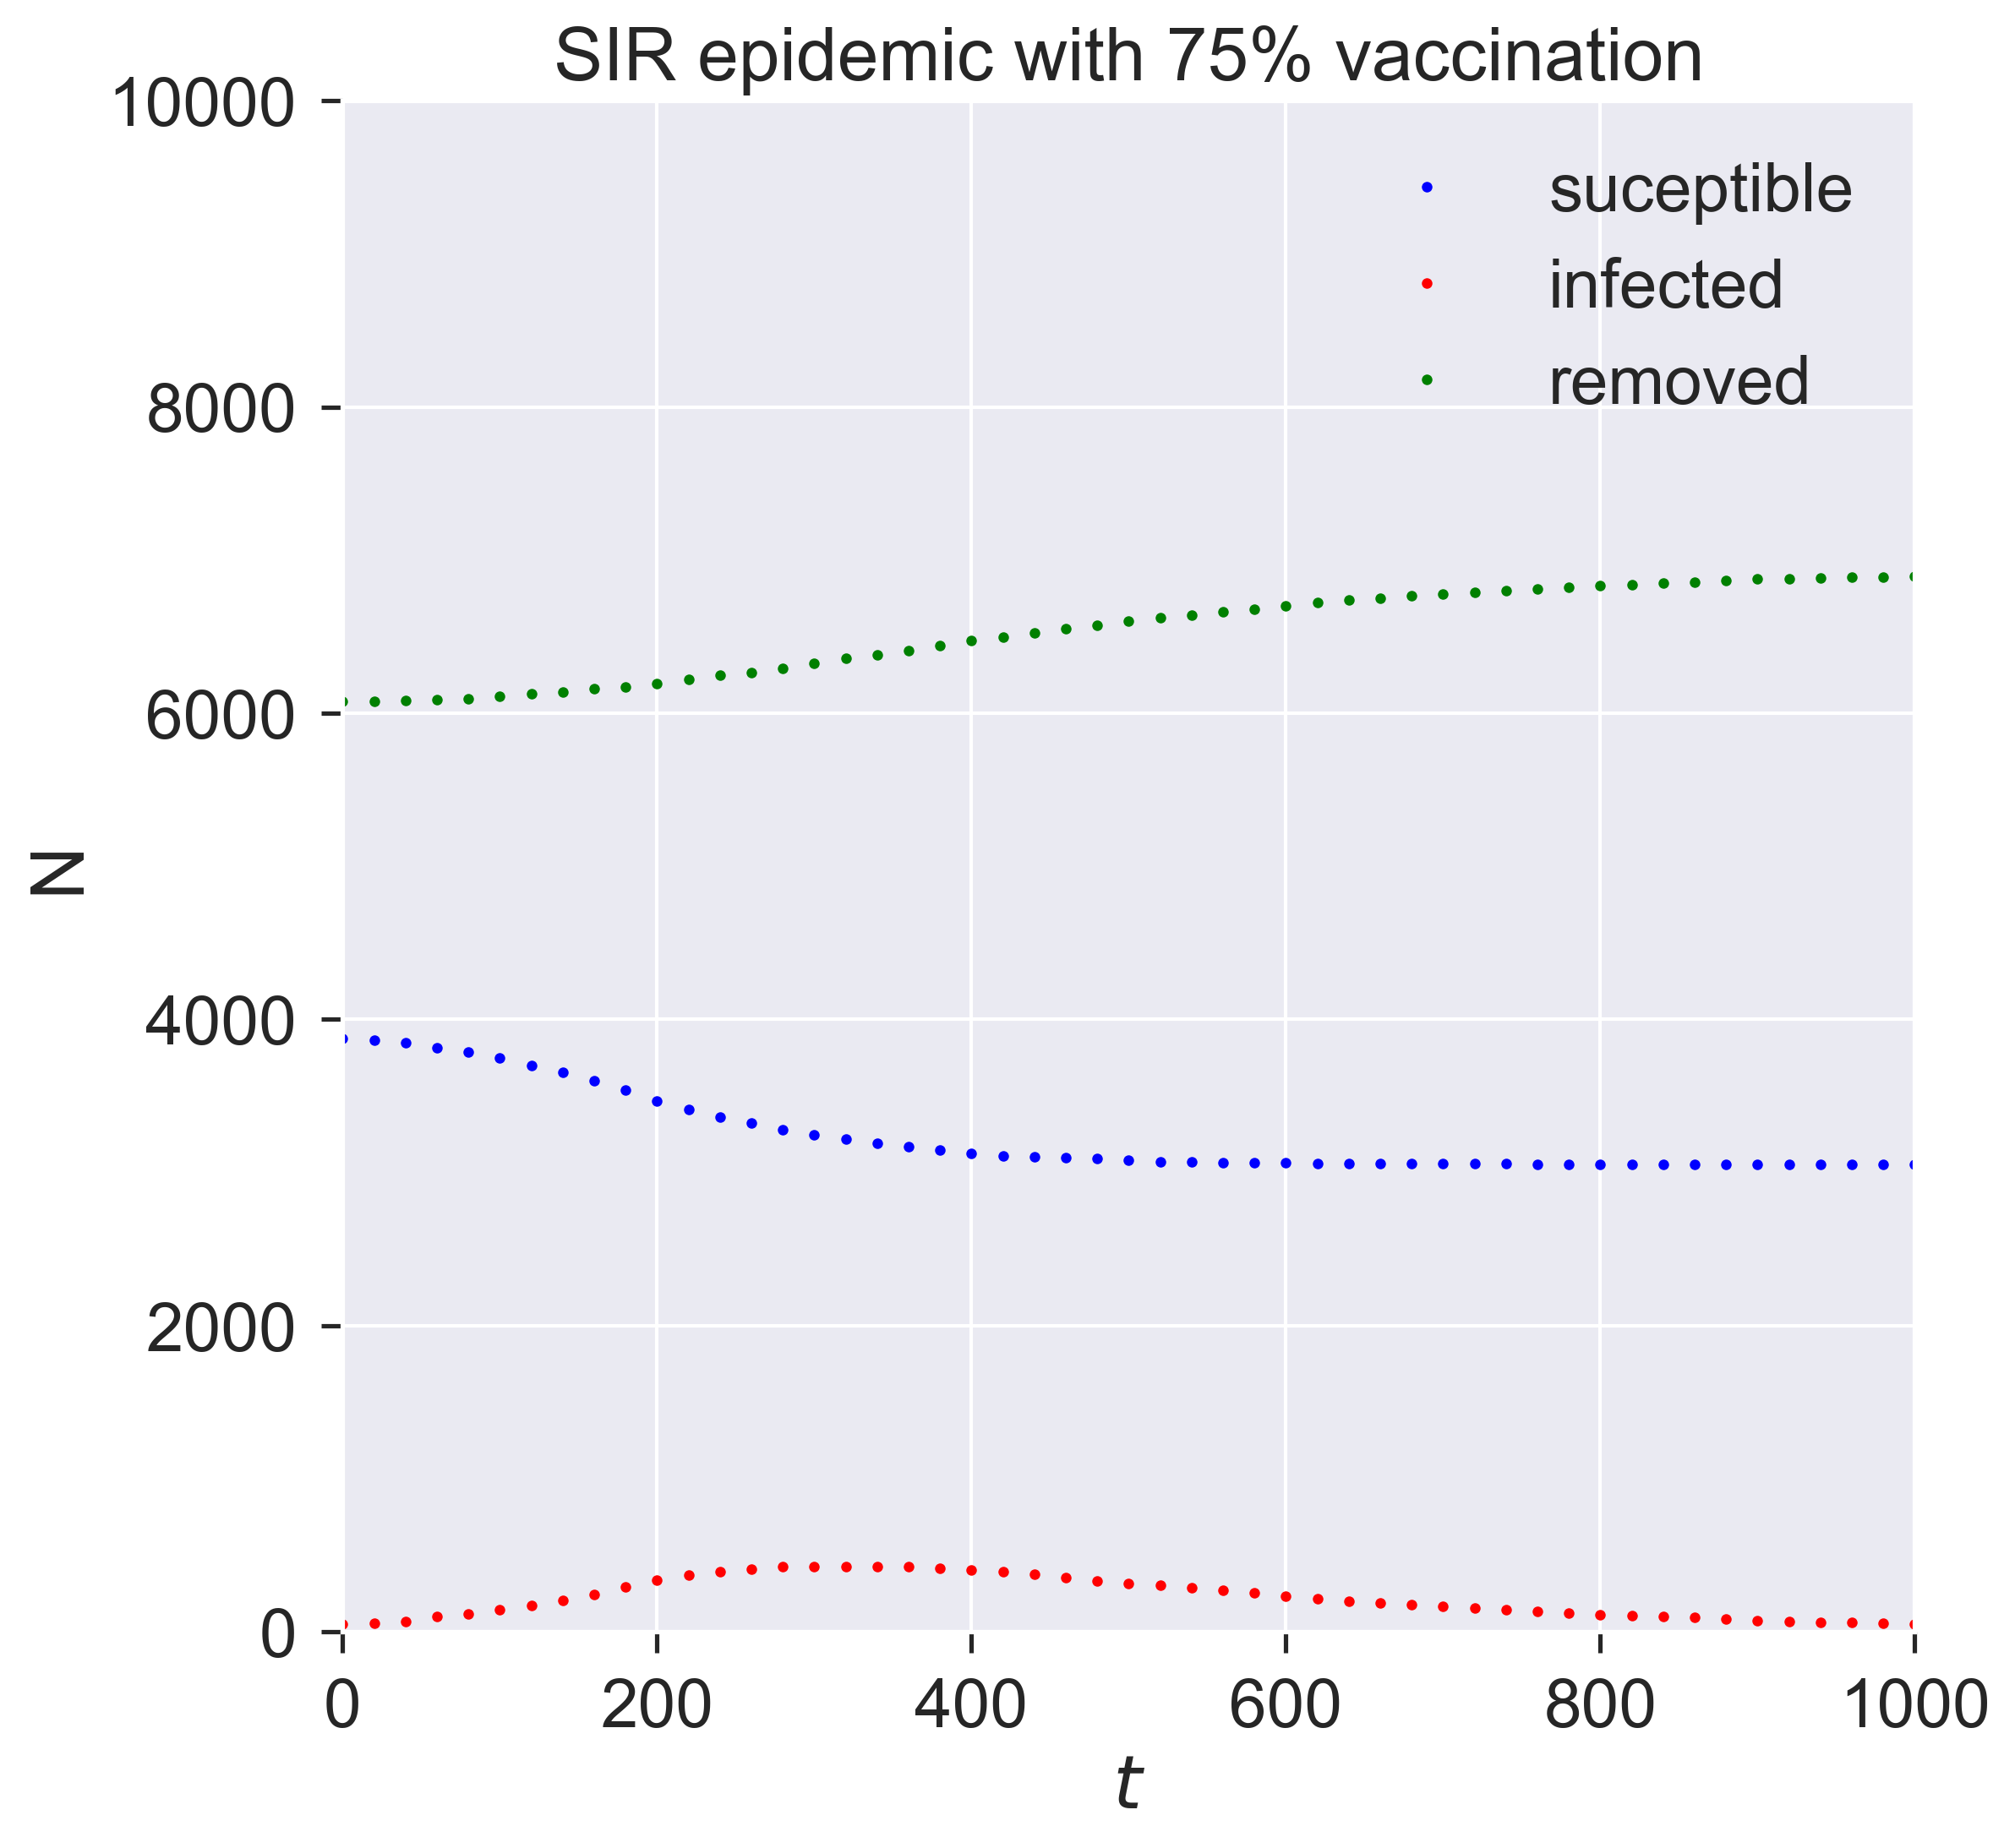

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

rc = df[df[MonitoredVaccinatedSIR.P_VACCINATED] == 0.75 * 0.8]
results = rc.iloc[0]
timeseries = results[epydemic.Monitor.TIMESERIES]
ts = timeseries[MonitoredVaccinatedSIR.OBSERVATIONS]
sss = timeseries[epydemic.SIR.SUSCEPTIBLE]
iss = timeseries[epydemic.SIR.INFECTED]
rss = timeseries[epydemic.SIR.REMOVED]
ax.plot(ts, sss, 'b.', label='suceptible')
ax.plot(ts, iss, 'r.', label='infected')
ax.plot(ts, rss, 'g.', label='removed')

ax.set_xlim([0, T])    
ax.set_xlabel('$t$')
ax.set_ylim([0, N])
ax.set_ylabel('N')
ax.set_title('SIR epidemic with 75% vaccination')
ax.legend(loc='upper right')

plt.show()

#### Vaccinating Super-Spreaders

In [11]:
kVaccinatedFraction = 0.02    # top 2% highest-degree nodes

In [12]:
lab[MonitoredVaccinatedHighDegreeSIR.K_VACCINATED_FRACTION] = kVaccinatedFraction

m = MonitoredVaccinatedHighDegreeSIR()
e = PLCNetworkDynamics(m)
lab.runExperiment(e)
df = lab.dataframe()

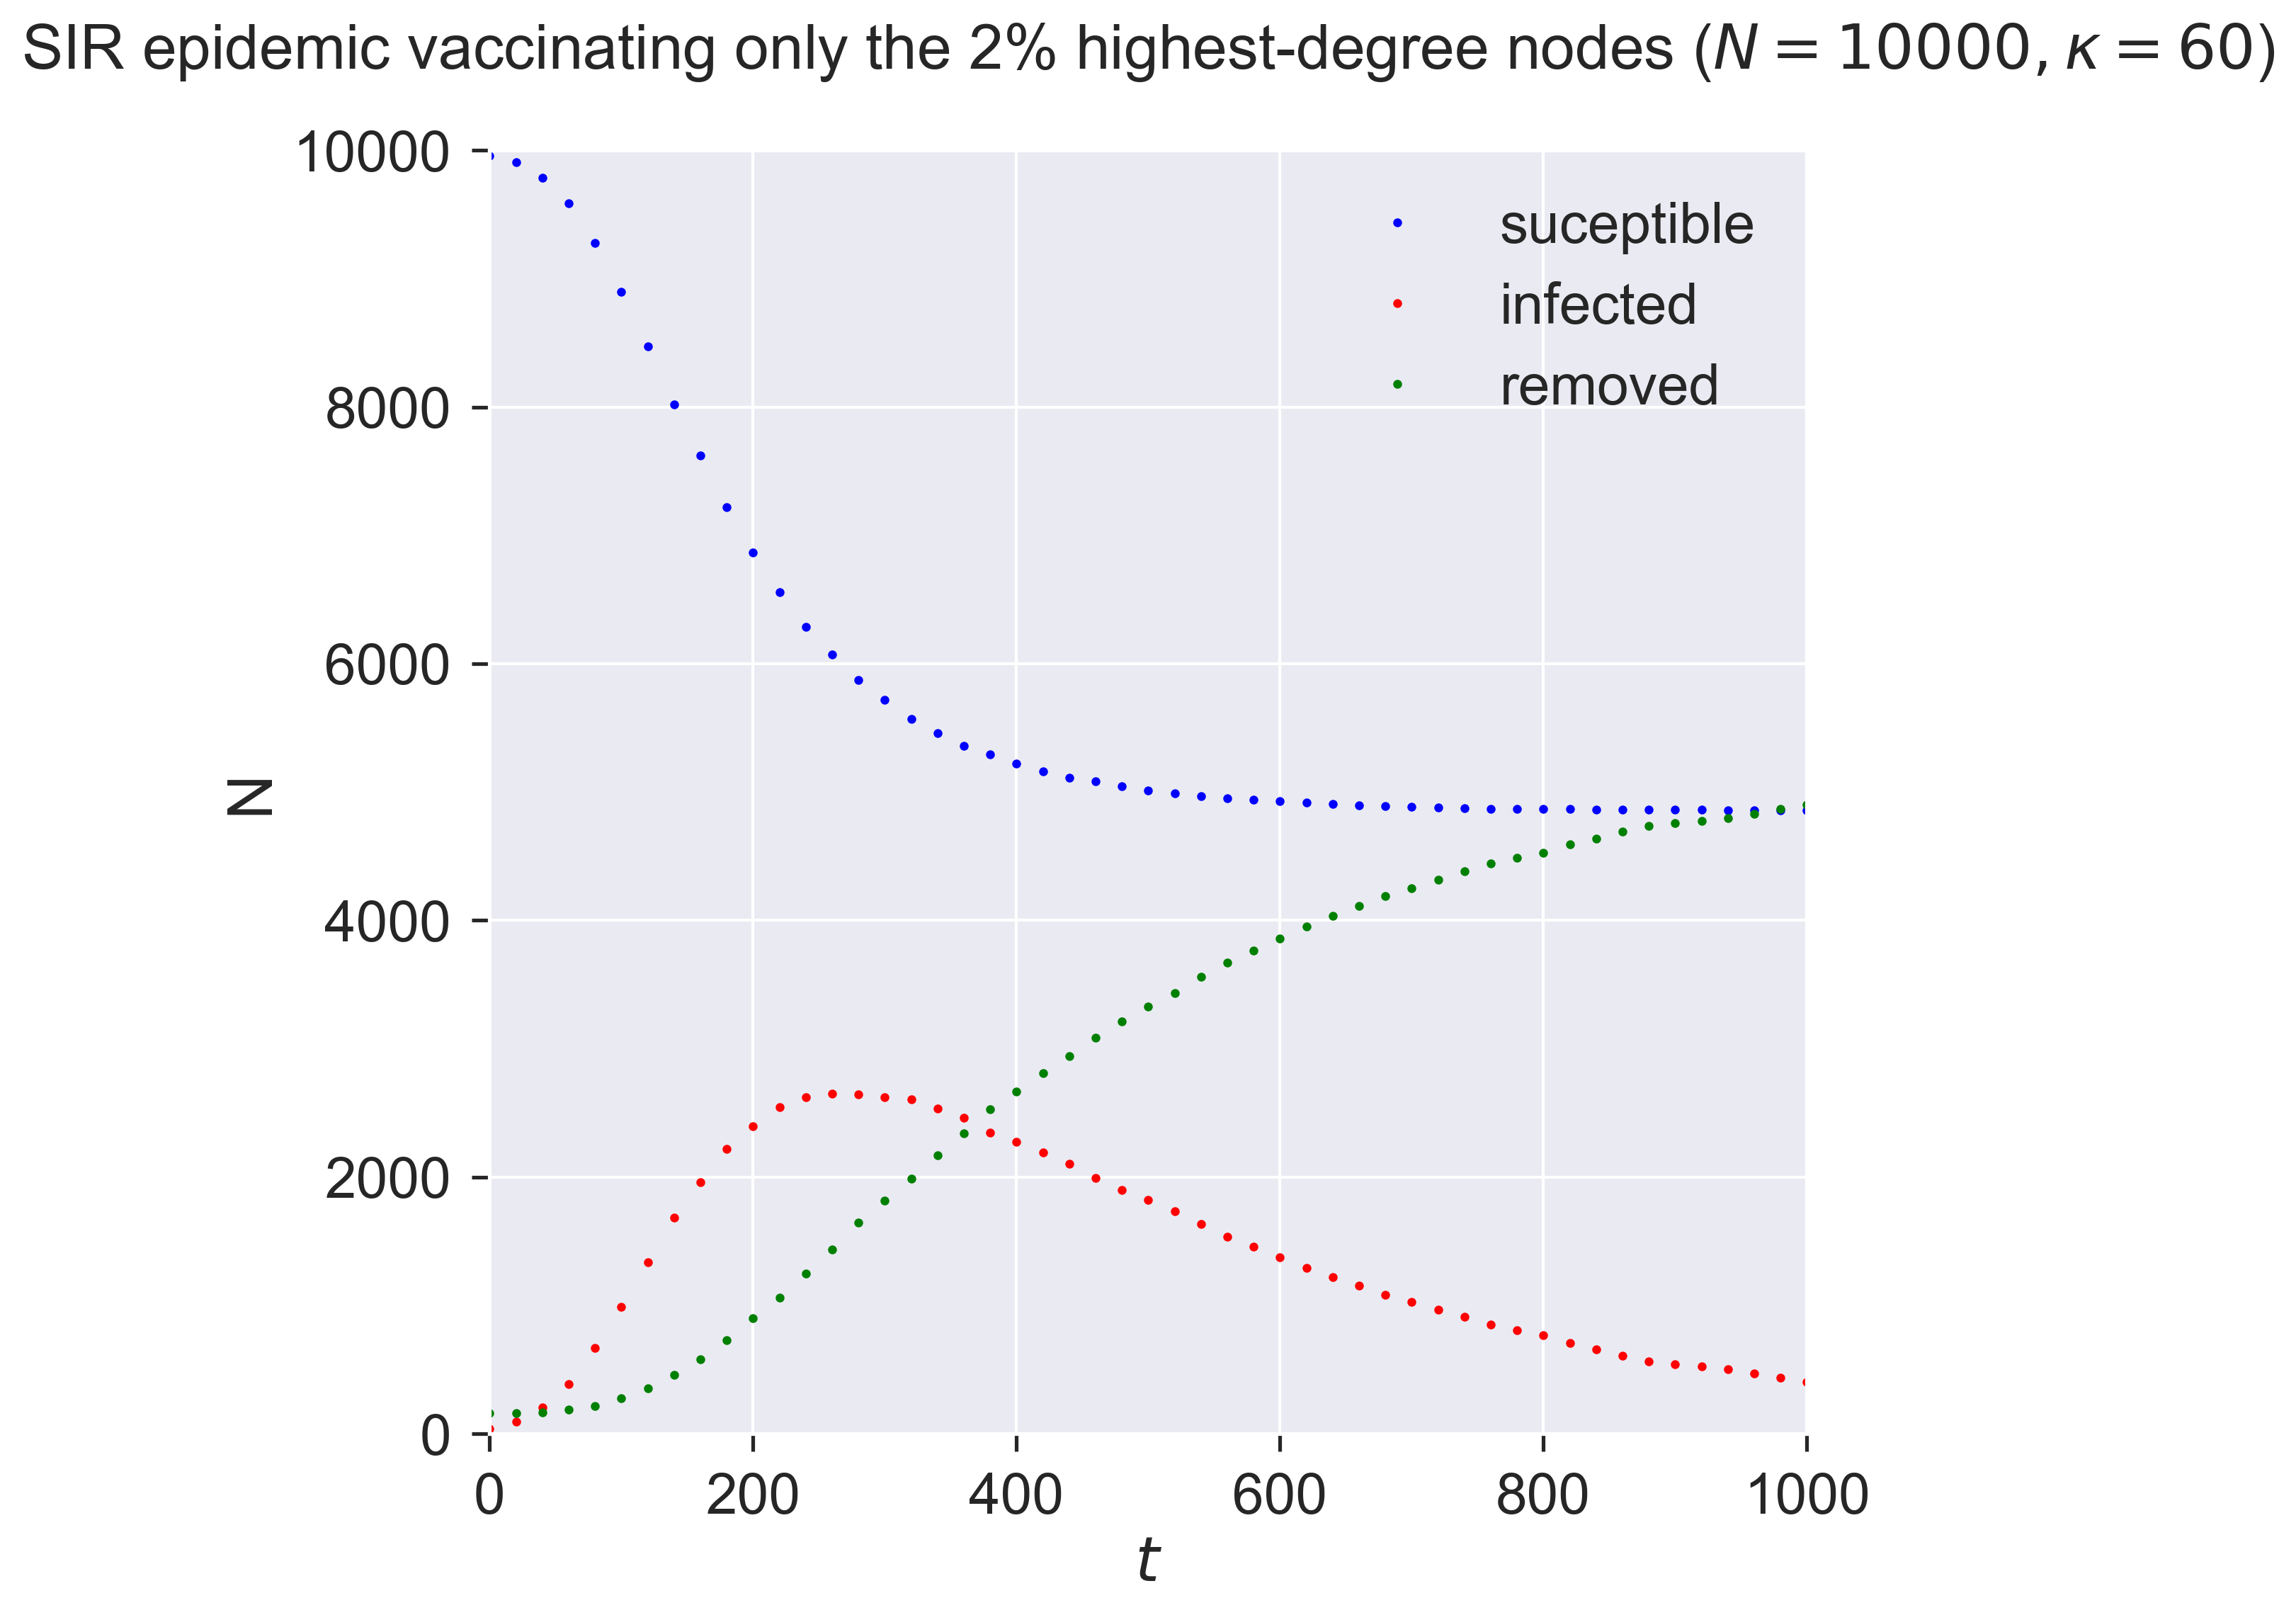

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

rc = df[df[MonitoredVaccinatedHighDegreeSIR.K_VACCINATED_FRACTION] == kVaccinatedFraction]
results = rc.iloc[0]
timeseries = results[epydemic.Monitor.TIMESERIES]
ts = timeseries[MonitoredVaccinatedSIR.OBSERVATIONS]
sss = timeseries[epydemic.SIR.SUSCEPTIBLE]
iss = timeseries[epydemic.SIR.INFECTED]
rss = timeseries[epydemic.SIR.REMOVED]
ax.plot(ts, sss, 'b.', label='suceptible')
ax.plot(ts, iss, 'r.', label='infected')
ax.plot(ts, rss, 'g.', label='removed')

ax.set_xlim([0, T])    
ax.set_xlabel('$t$')
ax.set_ylim([0, N])
ax.set_ylabel('N')
ax.set_title('SIR epidemic vaccinating only the {kvac:.0f}% highest-degree nodes ($N = {n}, \\kappa = {k:.0f}$)'.format(kvac=kVaccinatedFraction * 100, n=N, k=results[PLCNetworkDynamics.CUTOFF]), y=1.05)
ax.legend(loc='upper right')

plt.show()

## Simulations: General Population Vaccination (0%/50%/70%/90%) - Vaccine Efficacy 80%

In [14]:
# network parameters
N = 10000
alpha = 2

# simulation time
T = 1000

# disease dynamic parameters
pInfected = 0.005
pInfect = 0.01
pRemove = 1-exp(-1/14 * 0.05)

In [15]:
# set up the experiment
lab = epyc.Lab()
lab[epydemic.SIR.P_INFECTED] = pInfected
lab[epydemic.SIR.P_INFECT] = pInfect
lab[epydemic.SIR.P_REMOVE] = pRemove
lab[PLCNetworkDynamics.N] = N
lab[PLCNetworkDynamics.ALPHA] = alpha
lab[PLCNetworkDynamics.CUTOFF] = 60
lab[PLCNetworkDynamics.RDSEED] = 42

# timesteps
lab[epydemic.Monitor.DELTA] = T / 50

In [16]:
# proportion vaccinated
lab[MonitoredVaccinatedSIR.P_VACCINATED] = numpy.array([0.,0.5*0.8,0.7*0.8,0.9*0.8])

# run experiment
m = MonitoredVaccinatedSIR()
e = PLCNetworkDynamics(m)
rep = lab.runExperiment(epyc.RepeatedExperiment(e,10)) #run experiment 10 times

# get results
df = lab.dataframe()

In [17]:
# recalculating targeted proportion of pop
df['target'] = round(df['pVaccinated']/0.8 *100).astype(int)

#### Save Results

In [18]:
df.to_csv('gen_pop.csv')

#### Plots

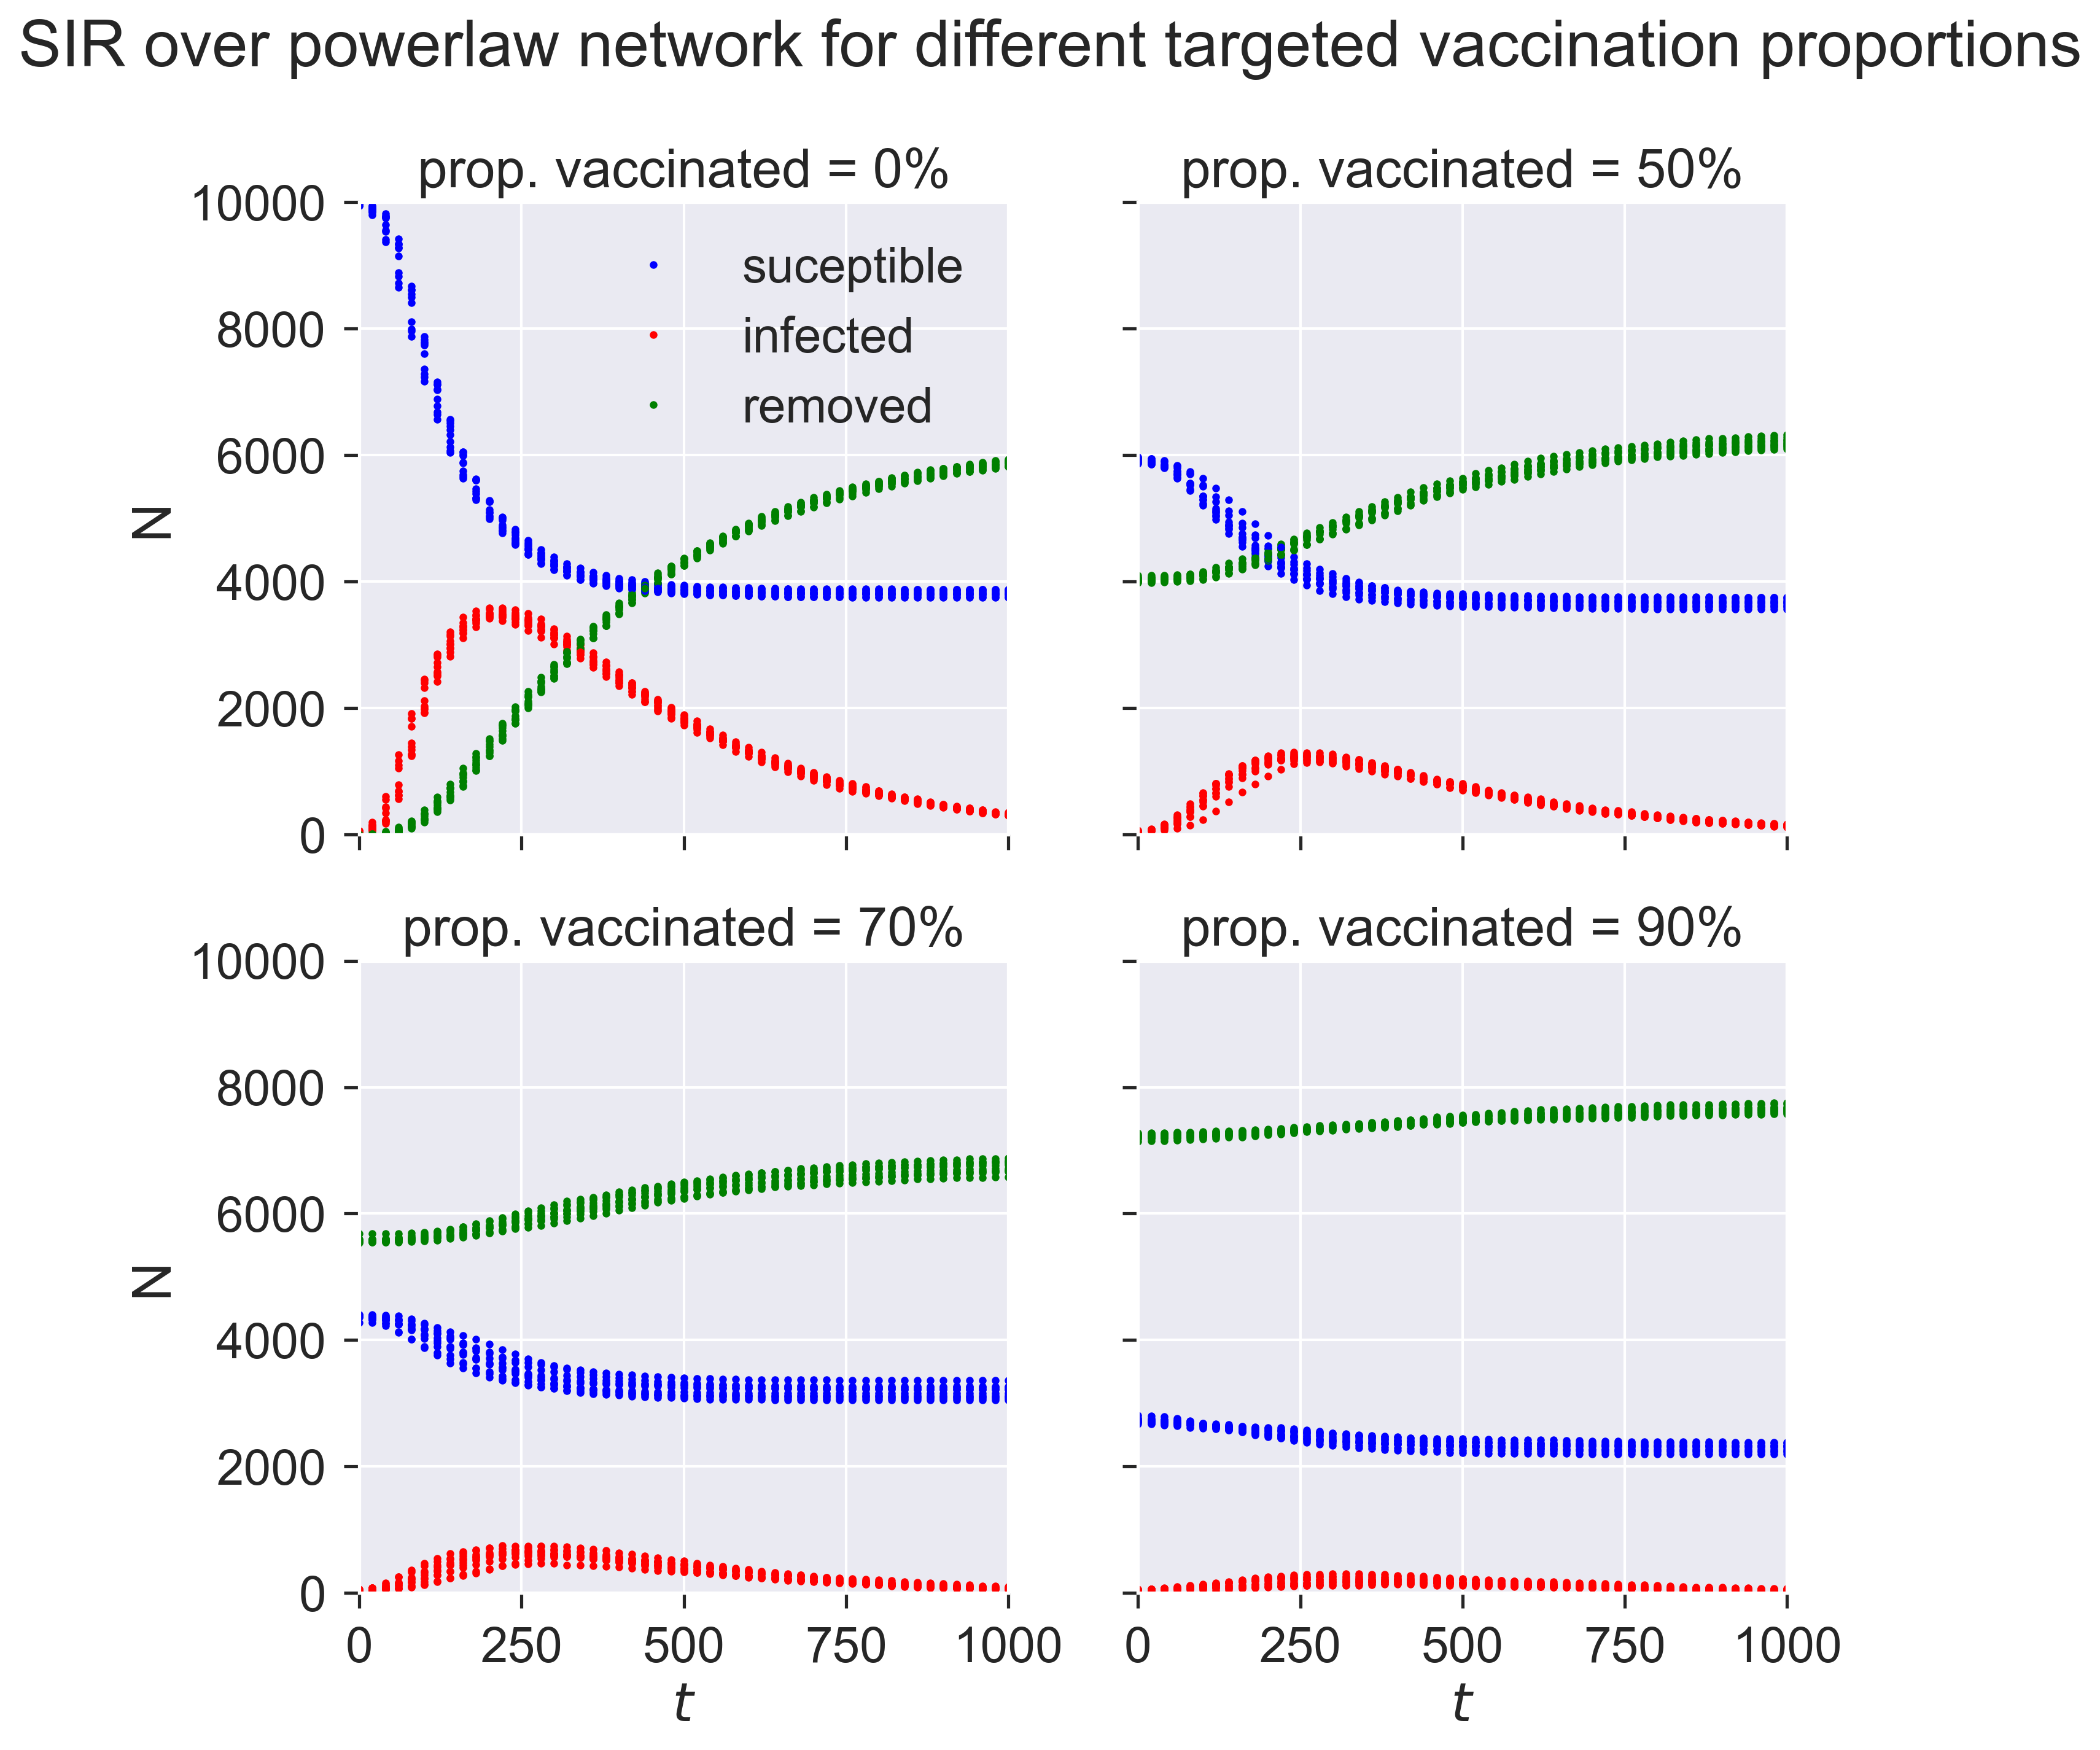

In [38]:
targets = df['target'].unique()
    
(fig, axs) = plt.subplots(2, 2, sharex=True, sharey=True,
                          figsize=(10, 10))

for (ax, cutoff) in [ (axs[0][0], targets[0]),
                      (axs[0][1], targets[1]),
                      (axs[1][0], targets[2]), 
                      (axs[1][1], targets[3]) ]:
    rc = df[df['target'] == cutoff]
    # plot sims
    for i in range(10):
        timeseries = rc[MonitoredSIR.TIMESERIES].iloc[i]
        ts = timeseries[MonitoredSIR.OBSERVATIONS]
        sss = timeseries[epydemic.SIR.SUSCEPTIBLE]
        iss = timeseries[epydemic.SIR.INFECTED]
        rss = timeseries[epydemic.SIR.REMOVED]
    
        ax.plot(ts, sss, 'b.', label='suceptible')
        ax.plot(ts, iss, 'r.', label='infected')
        ax.plot(ts, rss, 'g.', label='removed')
        if i == 0:
            ax.set_title('prop. vaccinated = {kappa}%'.format(kappa=cutoff))
            ax.set_xlim([0, T])
            ax.set_ylim([0, N])
            if ax == axs[0][0]:
                ax.legend(loc='upper right')

# fine-tune the diagram
plt.suptitle('SIR over powerlaw network for different targeted vaccination proportions')
for y in range(2):
    axs[y][0].set_ylabel('N')
for x in range(2):
    axs[1][x].set_xlabel('$t$')

plt.show()

#### Summary Statistics

In [20]:
# calculate total infected and max infected for each simulation
totinf_zer, totinf_fif, totinf_sev, totinf_nin, maxinf_zer, maxinf_fif, maxinf_sev, maxinf_nin = [], [], [], [], [], [], [], []

for i in range(10):
    totinf_zer.append(df[df['target'] == 0][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE][0] - df[df['target'] == 0].iloc[i]['epydemic.SIR.S'])
    totinf_fif.append(df[df['target'] == 50][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE][0] - df[df['target'] == 50].iloc[i]['epydemic.SIR.S'])
    totinf_sev.append(df[df['target'] == 70][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE][0] - df[df['target'] == 70].iloc[i]['epydemic.SIR.S'])
    totinf_nin.append(df[df['target'] == 90][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE][0] - df[df['target'] == 90].iloc[i]['epydemic.SIR.S'])
    maxinf_zer.append(max(df[df['target'] == 0][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE]))
    maxinf_fif.append(max(df[df['target'] == 50][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE]))
    maxinf_sev.append(max(df[df['target'] == 70][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE]))
    maxinf_nin.append(max(df[df['target'] == 90][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE]))

In [21]:
# create df for results
summary_gpop = pandas.DataFrame(data={'vac_zero_totinf': totinf_zer,
                                      'vac_zero_maxinf': maxinf_zer,
                                      'vac_fifty_totinf': totinf_fif,
                                      'vac_fifty_maxinf': maxinf_fif,
                                      'vac_seventy_totinf': totinf_sev,
                                      'vac_seventy_maxinf': maxinf_sev,
                                      'vac_ninety_totinf': totinf_nin,
                                      'vac_ninety_maxinf': maxinf_nin})

In [22]:
# save results
summary_gpop.to_csv('summary_gpop.csv')

In [23]:
# get final summary stats
summary_gpop.describe()

,vac_zero_totinf,vac_zero_maxinf,vac_fifty_totinf,vac_fifty_maxinf,vac_seventy_totinf,vac_seventy_maxinf,vac_ninety_totinf,vac_ninety_maxinf
count,10.000000,10.000000,10.000000,10.00000,10.000000,10.00000,10.000000,10.000000
mean,6135.600000,9950.800000,2258.700000,5921.00000,1189.500000,4371.40000,430.900000,2730.900000
std,43.846196,6.142746,55.027367,35.44009,122.334923,36.09309,75.816225,38.228698
min,6075.000000,9943.000000,2192.000000,5864.00000,914.000000,4279.00000,313.000000,2677.000000
25%,6109.750000,9945.250000,2204.250000,5897.25000,1130.500000,4366.75000,376.500000,2703.000000
50%,6138.500000,9951.000000,2260.500000,5929.50000,1205.000000,4376.00000,431.000000,2724.000000
75%,6155.000000,9953.500000,2308.000000,5948.00000,1263.500000,4393.50000,466.000000,2749.250000
max,6213.000000,9960.000000,2338.000000,5967.00000,1325.000000,4405.00000,569.000000,2807.000000


## Simulations: Vaccinating Super-Spreaders (1%/5%/10%) - Vaccine Efficacy 80%

In [33]:
# network parameters
N = 10000
alpha = 2

# simulation time
T = 1000

# disease dynamic parameters
pInfected = 0.005
pInfect = 0.01
pRemove = 1-exp(-1/14 * 0.05)

In [34]:
# set up the experiment
lab_sup = epyc.Lab()
lab_sup[epydemic.SIR.P_INFECTED] = pInfected
lab_sup[epydemic.SIR.P_INFECT] = pInfect
lab_sup[epydemic.SIR.P_REMOVE] = pRemove
lab_sup[PLCNetworkDynamics.N] = N
lab_sup[PLCNetworkDynamics.ALPHA] = alpha
lab_sup[PLCNetworkDynamics.CUTOFF] = 60
lab_sup[PLCNetworkDynamics.RDSEED] = 42

# timesteps
lab_sup[epydemic.Monitor.DELTA] = T / 50
lab_sup[MonitoredVaccinatedHighDegreeSIR.K_VACCINATED_FRACTION] = numpy.array([0.01,0.05,0.1,0.2])

# run experiment
m_sup = MonitoredVaccinatedHighDegreeSIR()
e_sup = PLCNetworkDynamics(m_sup)
rep_sup = lab_sup.runExperiment(epyc.RepeatedExperiment(e_sup,10)) #run experiment 10 times

# get results
df_sup = lab_sup.dataframe()

#### Save Results

In [35]:
df_sup.to_csv('sup_spreaders.csv')

#### Plots

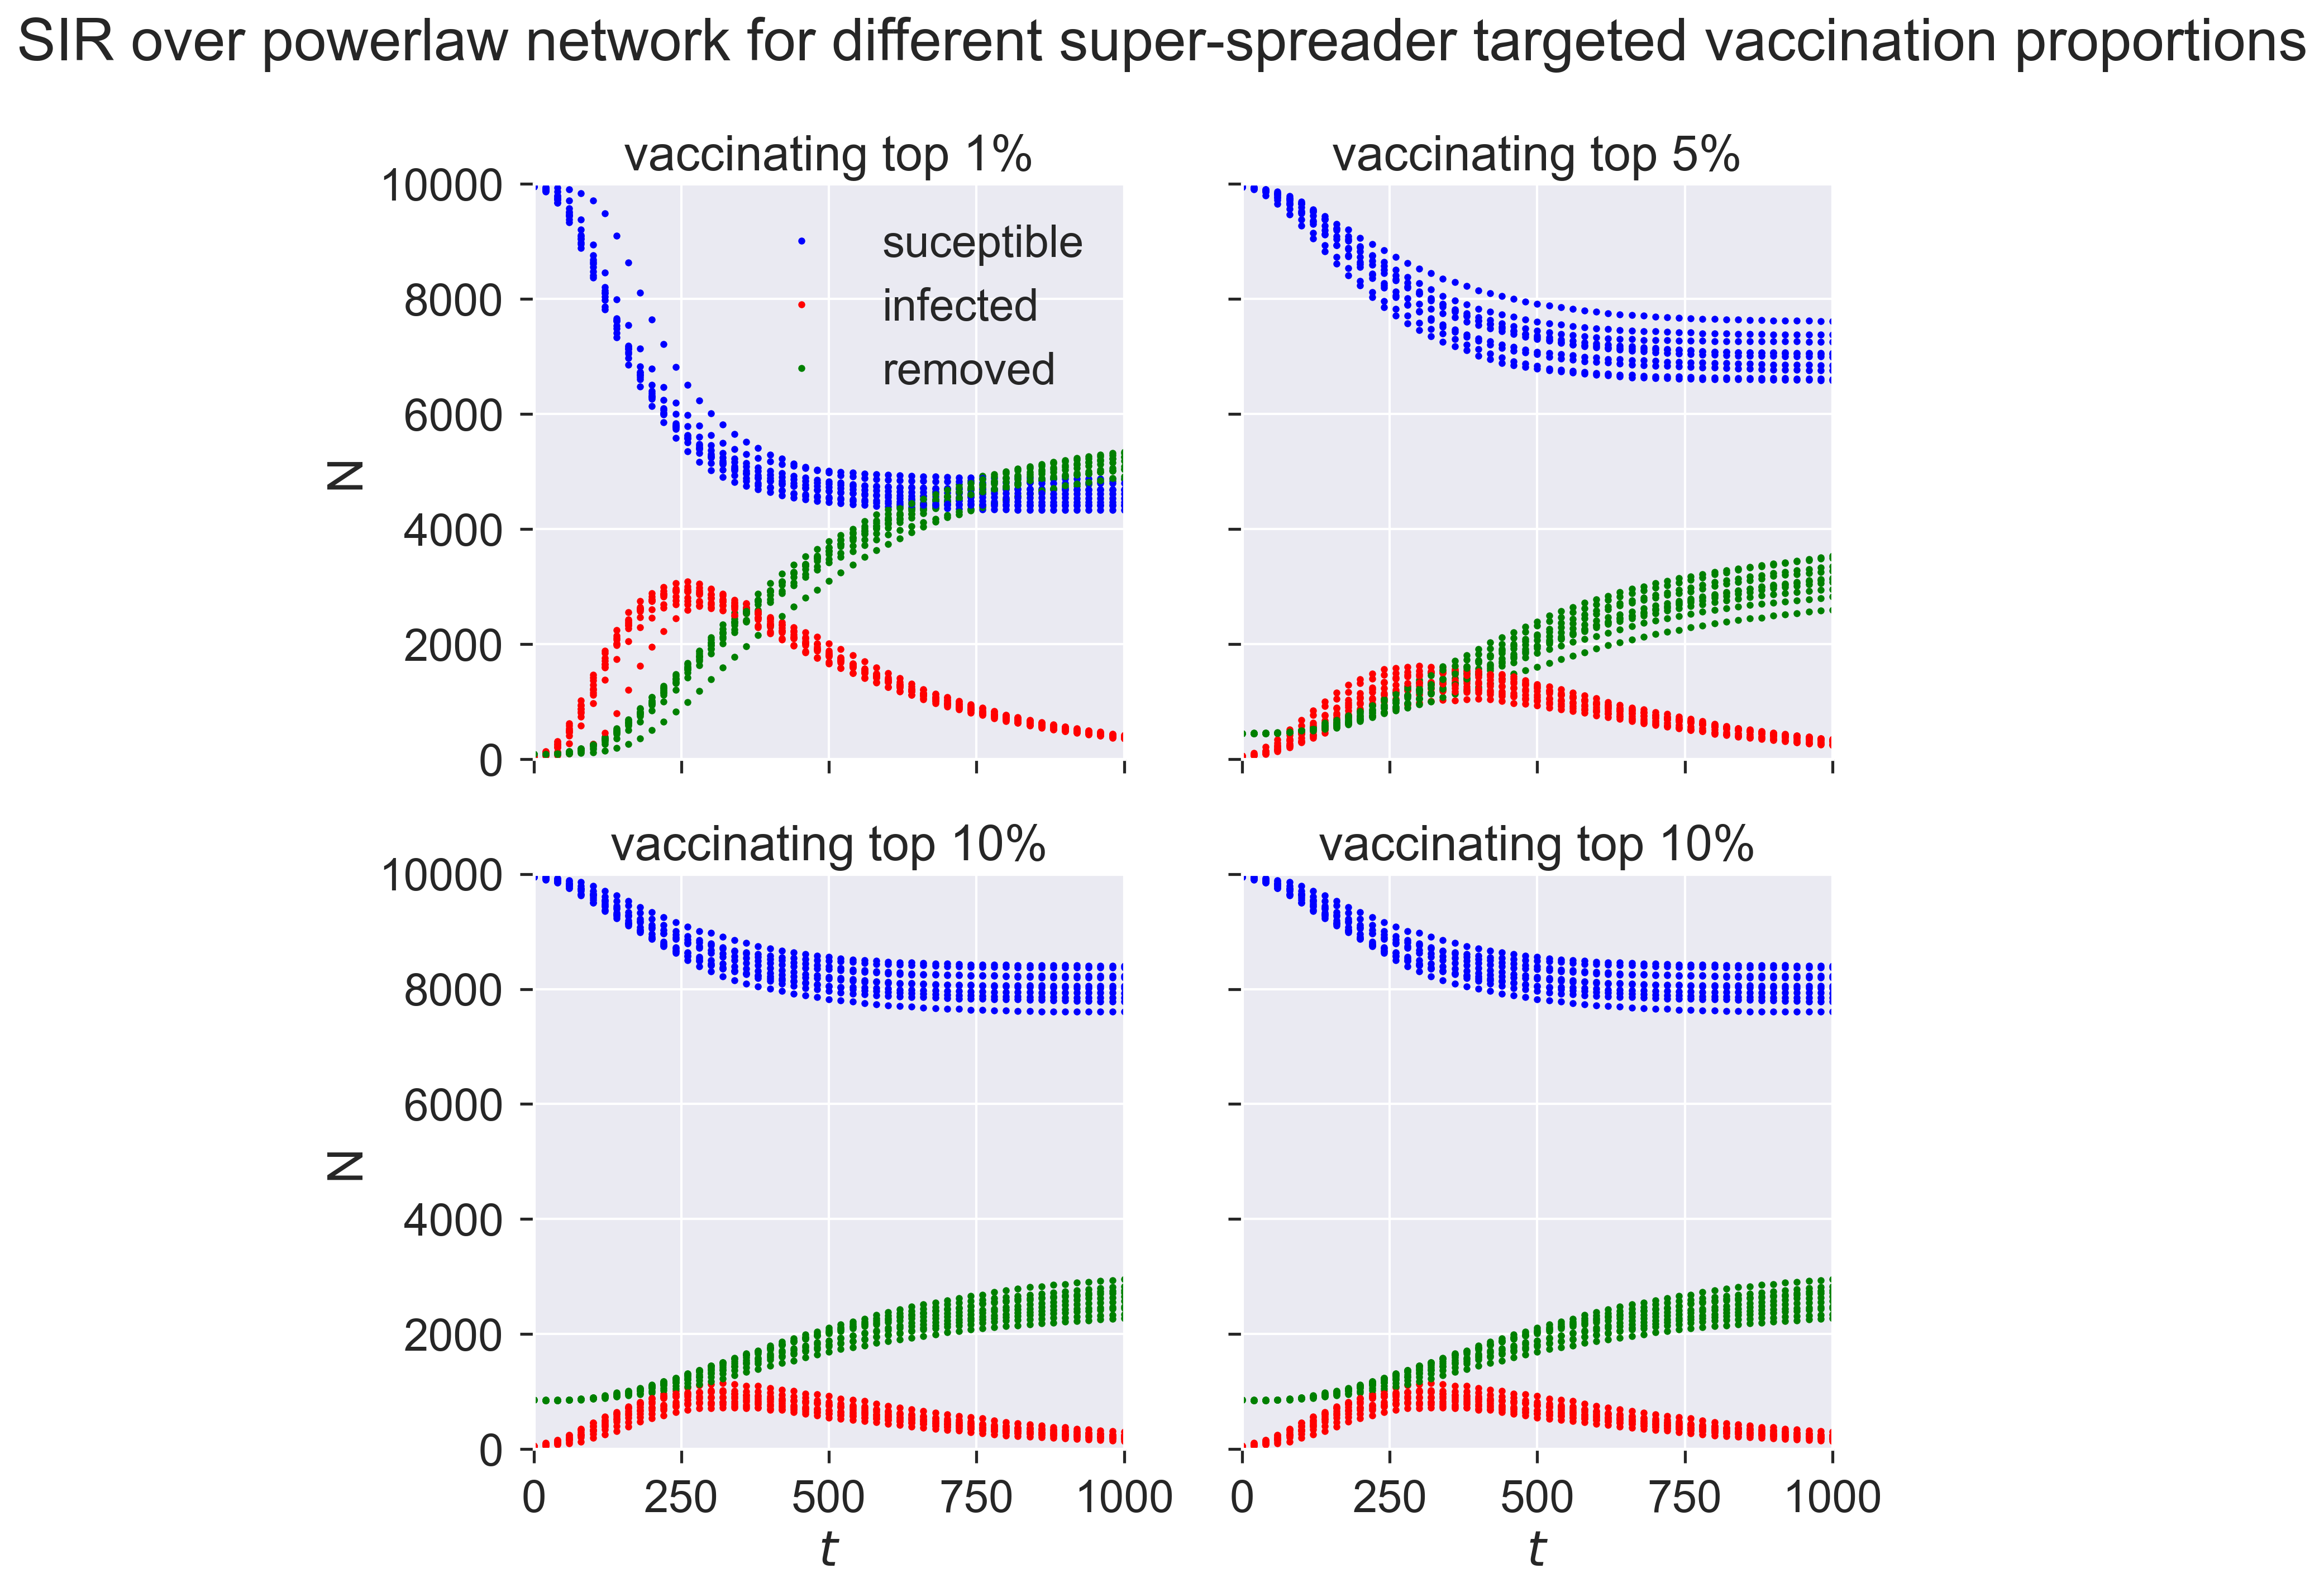

In [37]:
targets = df_sup['k_vaccinated_fraction'].unique()
    
(fig, axs) = plt.subplots(2, 2, sharex=True, sharey=True,
                          figsize=(10, 10))

for (ax, cutoff) in [ (axs[0][0], targets[0]),
                      (axs[0][1], targets[1]),
                      (axs[1][0], targets[2]), 
                      (axs[1][1], targets[2]) ]:
    rc = df_sup[df_sup['k_vaccinated_fraction'] == cutoff]
    # plot sims
    for i in range(10):
        timeseries = rc[MonitoredSIR.TIMESERIES].iloc[i]
        ts = timeseries[MonitoredSIR.OBSERVATIONS]
        sss = timeseries[epydemic.SIR.SUSCEPTIBLE]
        iss = timeseries[epydemic.SIR.INFECTED]
        rss = timeseries[epydemic.SIR.REMOVED]
    
        ax.plot(ts, sss, 'b.', label='suceptible')
        ax.plot(ts, iss, 'r.', label='infected')
        ax.plot(ts, rss, 'g.', label='removed')
        if i == 0:
            ax.set_title('vaccinating top {kappa}%'.format(kappa=round(cutoff*100)))
            ax.set_xlim([0, T])
            ax.set_ylim([0, N])
            if ax == axs[0][0]:
                ax.legend(loc='upper right')

# fine-tune the diagram
plt.suptitle('SIR over powerlaw network for different super-spreader targeted vaccination proportions')
for y in range(2):
    axs[y][0].set_ylabel('N')
for x in range(2):
    axs[1][x].set_xlabel('$t$')

plt.show()

#### Summary Statistics

In [39]:
# calculate total infected and max infected for each simulation
totinf_zer_s, totinf_fif_s, totinf_sev_s, totinf_nin_s, maxinf_zer_s, maxinf_fif_s, maxinf_sev_s, maxinf_nin_s = [], [], [], [], [], [], [], []

for i in range(10):
    totinf_zer_s.append(df_sup[df_sup['k_vaccinated_fraction'] == 0.01][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE][0] - df_sup[df_sup['k_vaccinated_fraction'] == 0.01].iloc[i]['epydemic.SIR.S'])
    totinf_fif_s.append(df_sup[df_sup['k_vaccinated_fraction'] == 0.05][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE][0] - df_sup[df_sup['k_vaccinated_fraction'] == 0.05].iloc[i]['epydemic.SIR.S'])
    totinf_sev_s.append(df_sup[df_sup['k_vaccinated_fraction'] == 0.1][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE][0] - df_sup[df_sup['k_vaccinated_fraction'] == 0.1].iloc[i]['epydemic.SIR.S'])
    totinf_nin_s.append(df_sup[df_sup['k_vaccinated_fraction'] == 0.2][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE][0] - df_sup[df_sup['k_vaccinated_fraction'] == 0.2].iloc[i]['epydemic.SIR.S'])
    maxinf_zer_s.append(max(df_sup[df_sup['k_vaccinated_fraction'] == 0.01][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE]))
    maxinf_fif_s.append(max(df_sup[df_sup['k_vaccinated_fraction'] == 0.05][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE]))
    maxinf_sev_s.append(max(df_sup[df_sup['k_vaccinated_fraction'] == 0.1][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE]))
    maxinf_nin_s.append(max(df_sup[df_sup['k_vaccinated_fraction'] == 0.2][MonitoredSIR.TIMESERIES].iloc[i][epydemic.SIR.SUSCEPTIBLE]))

In [40]:
# create df for results
summary_ssprd = pandas.DataFrame(data={'sprd_one_totinf': totinf_zer_s,
                                      'sprd_one_maxinf': maxinf_zer_s,
                                      'sprd_five_totinf': totinf_fif_s,
                                      'sprd_five_maxinf': maxinf_fif_s,
                                      'sprd_ten_totinf': totinf_sev_s,
                                      'sprd_ten_maxinf': maxinf_sev_s,
                                      'sprd_twenty_totinf': totinf_nin_s,
                                      'sprd_twenty_maxinf': maxinf_nin_s})

In [42]:
# save results
summary_ssprd.to_csv('summary_ssprd.csv')

In [43]:
# get final summary stats
summary_ssprd.describe()

,sprd_one_totinf,sprd_one_maxinf,sprd_five_totinf,sprd_five_maxinf,sprd_ten_totinf,sprd_ten_maxinf,sprd_twenty_totinf,sprd_twenty_maxinf
count,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5458.400000,9952.60000,3394.600000,9951.400000,2763.800000,9950.200000,2881.000000,9948.400000
std,177.985143,2.54733,328.926604,5.561774,258.285286,5.028806,196.899862,9.500877
min,5168.000000,9949.00000,2797.000000,9944.000000,2409.000000,9944.000000,2655.000000,9940.000000
25%,5350.250000,9950.50000,3200.500000,9946.500000,2598.000000,9946.500000,2727.750000,9943.250000
50%,5467.000000,9953.00000,3398.000000,9952.000000,2761.000000,9949.000000,2848.000000,9944.500000
75%,5607.500000,9954.75000,3620.500000,9955.750000,2934.750000,9953.500000,3020.250000,9950.250000
max,5709.000000,9956.00000,3806.000000,9959.000000,3211.000000,9960.000000,3244.000000,9969.000000
